In [26]:
import os
BRANDON = '/Users/brandonmarks/Desktop/Research Materials/hierarchical-bayesian-model-validation/'
YASH = '/Users/yashd/Desktop/hierarchical-bayesian-model-validation/'
HANNAH = ''
ZIXUN = ''

ROOT_DIR = BRANDON
os.chdir(ROOT_DIR + 'testing-framework/')

from utilities import *
from plot_utilities import *

from scipy import special
np.random.seed(42)
from tqdm import tqdm
import sys

In [2]:
import matlab.engine 
eng = matlab.engine.connect_matlab()

In [4]:
def compute_prior_cdf_using_phi(r, eta, n_samples = 10000, tail_bound = 0.05, tail_percent = 0.01, scale = 1, scipy_int=True, eng= None, enforce_assert=True, return_assert = False, return_xs=False, debug=False):
    
    beta = (eta + 1.5)/r 
    var_prior = scale * scipy.special.gamma(beta + 1/r)/scipy.special.gamma(beta)
    cheby = np.sqrt(var_prior/(tail_bound))
    n_tail = int(n_samples*tail_percent)
    
    # introduced additional bound in case chebyshev is unwieldy
    x_max = min(99, cheby) 
    if cheby < 120:
        n_tail = 0
        if debug:
            print(f"No tail")
    if debug:
        print(f"Chebyshev bound: {cheby}")

    xs = np.linspace(-x_max, x_max, n_samples-2*n_tail)
    xs = np.append(-np.logspace(np.log10(cheby), 2, n_tail), xs)
    xs = np.append(xs, np.logspace(2, np.log10(cheby), n_tail))

    prior_cdf = np.full(xs.shape, np.nan)

    for j in tqdm(range(len(xs))):

        x = xs[j]
        # Note that theta = variance, np.sqrt(theta) = SD
    

        def gen_gamma_density(theta):
            return (np.abs(r)/scipy.special.gamma(beta)) * (1/scale) * (theta/scale)**(r*beta - 1) * np.exp(-(theta/scale)**r)

        def integrand(theta):
            return stats.norm.cdf(x/np.sqrt(theta)) * gen_gamma_density(theta)

        if scipy_int:
            prior_cdf[j] = integrate.quad(integrand, 0, np.inf)[0]
        else:
            prior_cdf[j] = eng.compute_cdf_using_phi(float(r), float(eta), float(x), nargout=1)
    
    
    normalizer = prior_cdf[-1]
    first = prior_cdf[1]

    if debug:
        print("First CDF value:", first)
        print("Last CDF value:", normalizer)

    if return_assert:
        if not 0.05 > first > -0.05:
            return None
        if not 1.05 > normalizer > 0.95:
            return None    

    if enforce_assert:
        assert 0.05 > first > -0.05    
        assert 1.05 > normalizer > 0.95
    
    prior_cdf = prior_cdf/normalizer   

    k = int(0.01*len(xs))
    zero_padding = np.zeros(k)
    ones_padding = np.ones(k)

    pad_max = max(10e5, np.round(max(np.abs(xs)) ** 2))
    if debug:
        print(f"0, 1 padding bounds: {pad_max}")

    prior_cdf_padded = np.concatenate([zero_padding, prior_cdf, ones_padding])
    xs_padded = np.concatenate([
        np.linspace(-pad_max, xs[0] - 1e-5, k),
        xs,
        np.linspace(xs[-1] + 1e-5, pad_max, k)
    ])

    cdf_spline = interpolate.CubicSpline(x=xs_padded, y=prior_cdf_padded)

    
    if return_xs:
        return xs, cdf_spline
    else:
        return cdf_spline

In [6]:
xs, prior_cdf = compute_prior_cdf_using_phi(r = 0.5, eta = 2, n_samples= 1000, eng= eng, scipy_int= False, return_xs=True, debug = True)

No tail
Chebyshev bound: 33.46640106136302


100%|██████████| 1000/1000 [00:01<00:00, 613.33it/s]

First CDF value: 0.0005094475396235131
Last CDF value: 0.9994977384915893
0, 1 padding bounds: 1000000.0


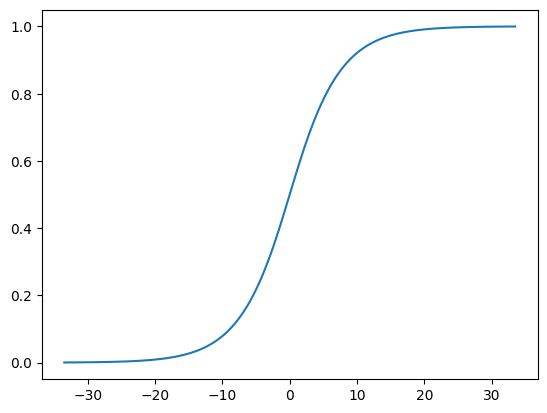

In [7]:
plt.plot(xs, prior_cdf(xs))

In [8]:
xs, prior_cdf = compute_prior_cdf_using_phi(r = 0.5, eta = 2, n_samples= 100, return_xs=True, debug = True)

No tail
Chebyshev bound: 33.46640106136302


100%|██████████| 100/100 [00:01<00:00, 58.29it/s]

First CDF value: 0.0005797445120281317
Last CDF value: 0.9994977384921377
0, 1 padding bounds: 1000000.0


In [10]:
xs, prior_cdf = compute_prior_cdf_using_phi(r = 0.2, eta = 2,  n_samples= 10000, eng= eng, scipy_int= False, return_xs=True, debug = True)

Chebyshev bound: 7459.90595617666


100%|██████████| 10000/10000 [00:19<00:00, 524.28it/s]

First CDF value: 0.002186880240124085
Last CDF value: 0.9981871279581372
0, 1 padding bounds: 55650197.0


In [11]:
xs, prior_cdf = compute_prior_cdf_using_phi(r = 0.2, eta = 2,  n_samples= 10000, eng= eng, scipy_int= True, return_xs=True, debug = True)

Chebyshev bound: 7459.90595617666


 27%|██▋       | 2711/10000 [00:06<00:19, 382.08it/s]/var/folders/0c/5hhs4r6n7pnc4jcl295d7j_c0000gn/T/ipykernel_77579/77987860.py:36: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  prior_cdf[j] = integrate.quad(integrand, 0, np.inf)[0]
 30%|██▉       | 2996/10000 [00:15<03:05, 37.75it/s]/var/folders/0c/5hhs4r6n7pnc4jcl295d7j_c0000gn/T/ipykernel_77579/77987860.py:36: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  prior_cdf[j] = integrate.quad(integrand, 0, np.inf)[0]
100%|██████████| 10000/10000 [02:33<00:00, 64.96it/s]


First CDF value: 0.0
Last CDF value: -3.6279876221888623e-10


AssertionError: 

In [14]:
xs, prior_cdf = compute_prior_cdf_using_phi(r = 0.13, eta = 2,  n_samples= 1000, eng= eng, scipy_int= False, return_xs=True, debug = True)

Chebyshev bound: 2199047.5643201894


100%|██████████| 1000/1000 [00:02<00:00, 420.05it/s]

First CDF value: 0.0
Last CDF value: 0.9972493653036226
0, 1 padding bounds: 4835810190143.0


In [166]:
def compute_prior_cdf_using_gamma_cdf(r, eta, n_samples = 10000, tail_bound = 0.05, tail_percent = 0.01, scale = 1, scipy_int=True, eng= None, enforce_assert=True, return_assert = False, return_xs=False, debug=False):
    
    beta = (eta + 1.5)/r 
    var_prior = scale * scipy.special.gamma(beta + 1/r)/scipy.special.gamma(beta)
        
    cheby = np.sqrt(var_prior/(tail_bound))
    if np.isnan(var_prior):
        cheby = 1e100
    n_tail = int(n_samples*tail_percent)
    
    # introduced additional bound in case chebyshev is unwieldy
    x_max = min(99, cheby) 
    if cheby < 120:
        n_tail = 0
        if debug:
            print(f"No tail")
    if debug:
        print(f"Chebyshev bound: {cheby}")

    xs = np.linspace(-x_max, x_max, n_samples-2*n_tail)
    xs = np.append(-np.logspace(np.log10(cheby), 2, n_tail), xs)
    xs = np.append(xs, np.logspace(2, np.log10(cheby), n_tail))

    prior_cdf = np.full(xs.shape, np.nan)

    if debug:
        loop = tqdm(range(len(xs)))
    else:
        loop = range(len(xs))
    for j in loop:

        x = xs[j]
        # Note that theta = variance, np.sqrt(theta) = SD
        def gauss_density(z):
            return (1/(np.sqrt(2*np.pi)) * np.exp(-0.5*(x**2)))

        def gen_gamma_cdf(x):
            return special.gammainc(beta, x**r)

        def integrand(z):
            return gauss_density(z) * (1-gen_gamma_cdf((x/z)**2))

        if scipy_int:
            res = integrate.quad(integrand, 0, np.inf)[0]
            if x > 0:
                res = 1-res
            prior_cdf[j] = res
        else:
            prior_cdf[j] = eng.compute_cdf_using_gengamma(float(r), float(eta), float(x), nargout=1)
        
    normalizer = prior_cdf[-1]
    first = prior_cdf[1]

    if debug:
        print("First CDF value:", first)
        print("Last CDF value:", normalizer)

    if return_assert:
        if not 0.05 > first > -0.05:
            return None
        if not 1.05 > normalizer > 0.95:
            return None    

    if enforce_assert:
        assert 0.01 > first > -0.01    
        assert 1.01 > normalizer > 0.99
    
    prior_cdf = (prior_cdf - first)
    normalizer_new = prior_cdf[-1]
    prior_cdf = prior_cdf/normalizer_new

    if cheby > 1e10:
        k = 10
    else:
        k = int(0.01*len(xs))
   

    zero_padding = np.zeros(k)
    ones_padding = np.ones(k)
    
    pad_max = max(10e5, np.round(max(np.abs(xs)) ** 2))
    step_size = (pad_max - xs[0]/2)/k
    
    if debug:
        print(f"0, 1 padding bounds: {pad_max}")

    prior_cdf_padded = np.concatenate([zero_padding, prior_cdf, ones_padding])
    xs_padded = np.concatenate([
        np.arange(-pad_max, xs[0]/2, step_size),
        xs,
        np.arange(xs[-1] *2, pad_max, step_size)
    ])

    cdf_spline = interpolate.CubicSpline(x=xs_padded, y=prior_cdf_padded, bc_type=((1, 0.0), (1, 0.0)))

    if enforce_assert:
        x = np.sort(sample_prior(r, eta, 100000))
        res = stats.ks_1samp(x, cdf_spline)
        assert 0 <= res.statistic <= 1
        if res.pvalue < 0.01:
            assert np.abs(res.statistic_location) > cheby
    if return_assert:
        x = np.sort(sample_prior(r, eta, 100000))
        res = stats.ks_1samp(x, cdf_spline)
        if not 0 <= res.statistic <= 1:
            return None
        if res.pvalue < 0.01:
            if not np.abs(res.statistic_location) > cheby:
                return None

    if return_xs:
        return xs, cdf_spline
    else:
        return cdf_spline

In [170]:
xs, prior_cdf = compute_prior_cdf_using_gamma_cdf(r = 0.03, eta = 2, n_samples= 2000, scipy_int=False, eng = eng, debug = True, return_xs = True, tail_percent = 0.1)

Chebyshev bound: 1.046890876954065e+36


100%|██████████| 2000/2000 [00:02<00:00, 846.28it/s]


First CDF value: 0.006108396893790122
Last CDF value: 0.996881370891471
0, 1 padding bounds: 1.0959805082496425e+72


In [171]:
x = np.sort(sample_prior(0.03, 2, 100000))
stats.ks_1samp(x, prior_cdf)

KstestResult(statistic=0.028796557006413037, pvalue=1.7887647680746212e-72, statistic_location=1.3625808802812387e+37, statistic_sign=1)

In [148]:
prior_cdf(6.0961567* 1e33)

array(0.65773499)

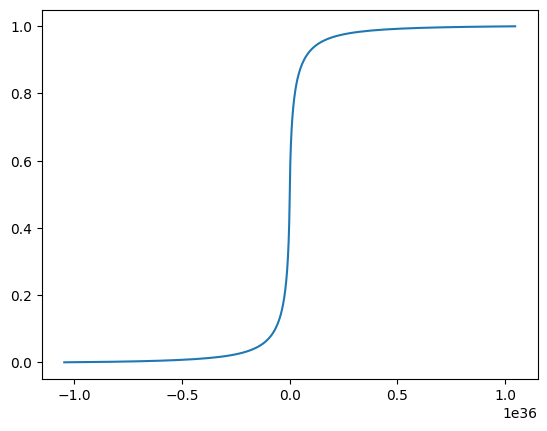

In [61]:
plt.plot(xs, prior_cdf(xs))


In [129]:
prior_cdf(1e10)

array(1.)